# Lab 3: Bayes Classifier and Boosting

## Import the libraries

In [1]:
import numpy as np
from scipy import misc
from importlib import reload
from labfuns import *
import random

/var/folders/bl/wz4tv3rs7vsd1fmkwrz2gnsc0000gn/T/ipykernel_89169/419916758.py:2: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


## Assignment 1

In [2]:
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

  # Map each sample to its class index [0..Nclasses-1]
    inv = np.searchsorted(classes, labels.reshape(-1))

    # Counts per class Nk (C x 1 for broadcasting)
    Nk = np.bincount(inv, minlength=Nclasses).astype(float).reshape(Nclasses, 1)

    # Class-wise sums -> means (ML)
    np.add.at(mu, inv, X)
    mu /= Nk

    # Per-class squared deviations -> variances (diagonal ML)
    dif = X - mu[inv]                       # broadcast μ_k to each row
    var_sum = np.zeros((Nclasses, Ndims))
    np.add.at(var_sum, inv, dif * dif)
    var = var_sum / Nk                      # divisor Nk (ML, not Nk-1)

    # Build diagonal covariance matrices
    idx = np.arange(Ndims)
    sigma[:, idx, idx] = var

    return mu, sigma

In [3]:
# 1) Generate test data
X, labels = genBlobs()                

# 2) ML estimates (means and diagonal covariances)
mu, sigma = mlParams(X, labels)

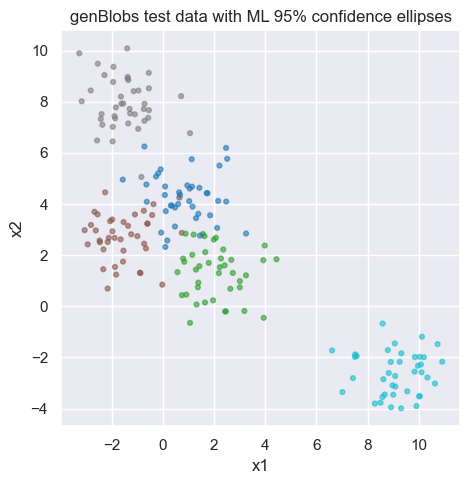

In [4]:
# 3) Plot points + 95% confidence ellipses
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=labels, s=12, alpha=0.6, cmap='tab10')
plt.gca().set_aspect('equal', adjustable='box')
plt.title("genBlobs test data with ML 95% confidence ellipses")
plt.xlabel("x1"); plt.ylabel("x2")
plt.tight_layout()
plt.show()

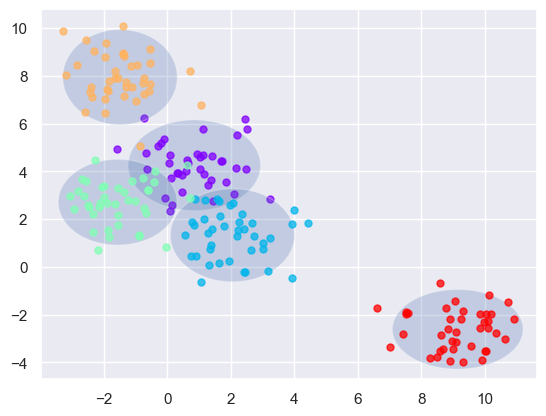

In [5]:
plotGaussian(X,labels,mu,sigma)           # uses 95% CI internally (per the lab)

## Assignment 2

In [6]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts, 1)) / float(Npts)  # uniform weights → count/N
    else:
        assert (W.shape[0] == Npts)
        if W.ndim == 1:
            W = W.reshape(-1, 1)

    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros((Nclasses, 1))

    # Map labels to compact indices 
    inv = np.searchsorted(classes, labels.reshape(-1))

    # Sum weights per class → prior (with uniform W this is Nk/N)
    np.add.at(prior, inv, W)

    # Safety: ensure priors sum to 1
    s = prior.sum()
    if s > 0:
        prior /= s

    return prior

In [7]:
def classifyBayes(X, prior, mu, sigma):
    Npts, Ndims = X.shape
    Nclasses = mu.shape[0]

    # Extract the diagonal variances for each class (shape: C x d)
    var = np.diagonal(sigma, axis1=1, axis2=2)
    var = np.maximum(var, 1e-12)  # avoid division by zero

    # Precompute constants for the Gaussian log-likelihood
    const = -0.5 * Ndims * np.log(2.0 * np.pi)        # constant term per class
    logdet = np.sum(np.log(var), axis=1)              # log |Σ_k| = sum of log variances
    inv_var = 1.0 / var                               # (C x d) reciprocal variances

    # Broadcasting shapes: (C,1,d) - (1,N,d) → (C,N,d)
    diff = X[None, :, :] - mu[:, None, :]
    quad = np.sum((diff * diff) * inv_var[:, None, :], axis=2)  # shape: (C,N)

    # Compute log-likelihood for each class and data point:
    # log N(x|μ_k,Σ_k) = const - 0.5 * (quad + log|Σ_k|)
    loglike = const - 0.5 * (quad + logdet[:, None])

    # Compute log-prior for each class
    # Add a small epsilon to avoid log(0)
    logprior = np.log(np.maximum(prior.reshape(-1, 1), 1e-300))

    # Combine likelihood and prior → log posterior (up to normalization)
    # log p(k|x) ∝ log p(x|k) + log p(k)
    logProb = logprior + loglike                       # shape: (C,N)

    # Choose the most probable class per sample (MAP)
    h = np.argmax(logProb, axis=0)

    return h


## Assignment 3

In [8]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

In [9]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


In [10]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:257: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,

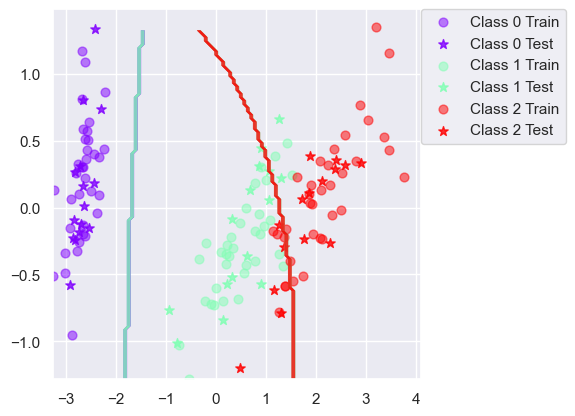

In [11]:
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
/Users/davidbazalduamendez/Documents/GitHub/Lab-3-Bayes-Classifier/labfuns.py:257: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,

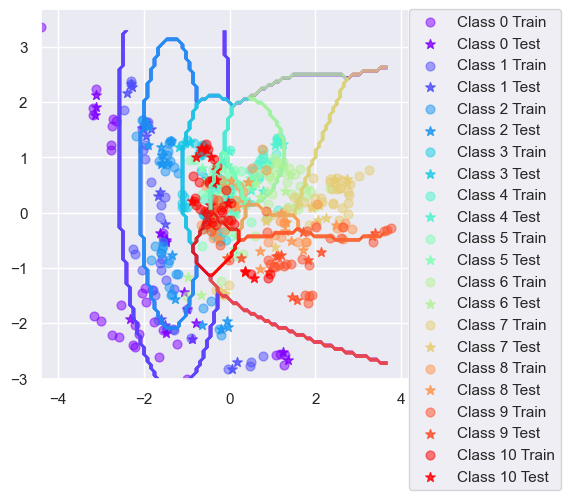

In [12]:
plotBoundary(BayesClassifier(), dataset='vowel',split=0.7)

The feature independence assumption can be reasonable when features are weakly correlated or describe unrelated aspects of the data, since the diagonal covariance approximation is then accurate. It becomes unreasonable when features are highly correlated, as in the Iris dataset, because ignoring their dependence prevents the model from capturing the real class structure.

The decision boundaries for the Iris dataset are smooth but rigid and mostly axis-aligned, reflecting the diagonal covariance assumption. Although the model performs well because the classes are clearly separated, accuracy could be improved by allowing full covariance matrices, using a discriminative classifier (e.g. SVM or Logistic Regression), or applying PCA to decorrelate the features.